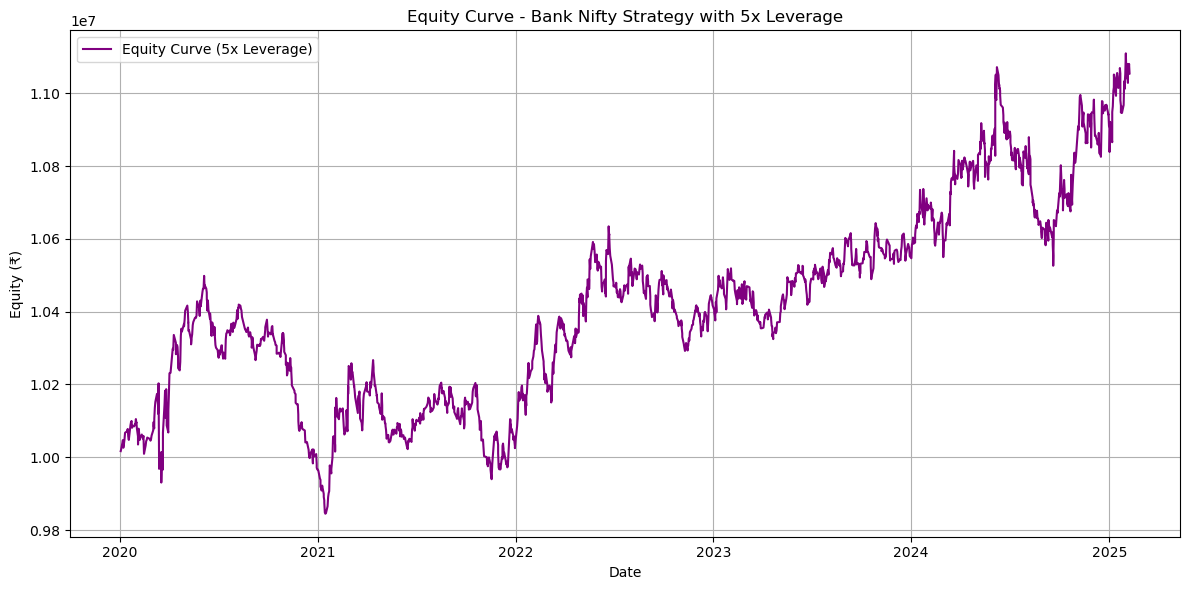

=== Strategy Performance Metrics (5x Leverage) ===
Initial Capital     : ₹10,000,000
Effective Capital   : ₹50,000,000
Total PnL           : ₹1,054,444
Sharpe Ratio        : 0.41
Max Drawdown        : ₹653,456
Calmar Ratio        : 1.61


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# Indicators
df["SMA_5"] = df["close"].rolling(window=5).mean()
df["SMA_13"] = df["close"].rolling(window=13).mean()
df["EMA_9"] = df["close"].ewm(span=9, adjust=False).mean()

# Time Filters
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["time_only"] = df["datetime"].dt.time

# Strategy Parameters
target = 200
stoploss = 50
position = None
entry_price = 0
entry_time = None
trades = []

# Trade Logic
for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["datetime"].time()
    price = row["close"]

    # Entry
    if time(9, 30) <= current_time <= time(11, 0):
        if position is None:
            if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
                position = "long"
                entry_price = price
                entry_time = row["datetime"]
            elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
                position = "short"
                entry_price = price
                entry_time = row["datetime"]

    # Exit
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

# Add leverage
initial_capital = 1e7  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage

# Position sizing based on effective capital
position_size = 15 * 25  # 15 lots * 25 per lot

# Compute PnL with leverage
trades_df["pnl_amount"] = trades_df["pnl"] * position_size

# Equity curve with actual capital but leveraged positions
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# Metrics
total_pnl_amount = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
max_drawdown = (trades_df["equity"].cummax() - trades_df["equity"]).max()
calmar_ratio = total_pnl_amount / max_drawdown if max_drawdown != 0 else np.nan

# Plot
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve (5x Leverage)", color="purple")
plt.title("Equity Curve - Bank Nifty Strategy with 5x Leverage")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final Metrics Summary
print("=== Strategy Performance Metrics (5x Leverage) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl_amount:,.0f}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown        : ₹{max_drawdown:,.0f}")
print(f"Calmar Ratio        : {calmar_ratio:.2f}")


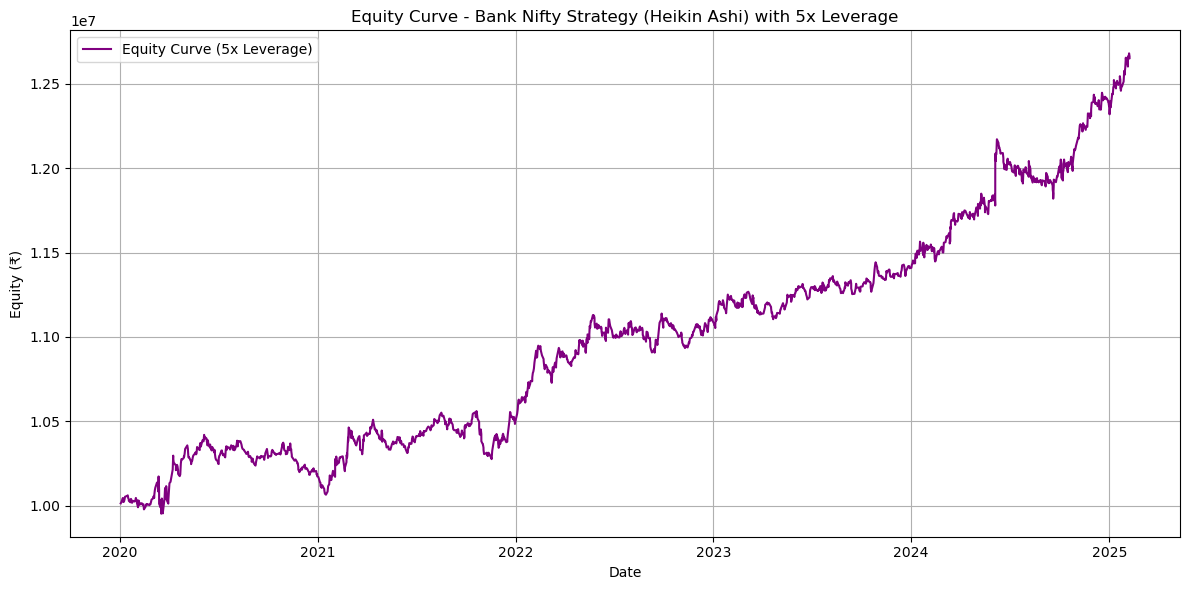

=== Strategy Performance Metrics (Heikin Ashi, 5x Leverage) ===
Initial Capital     : ₹10,000,000
Effective Capital   : ₹50,000,000
Total PnL           : ₹2,653,294
Sharpe Ratio        : 1.07
Max Drawdown        : ₹354,900
Calmar Ratio        : 7.48


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# Calculate Heikin Ashi candles
ha_df = df.copy()

# Initialize HA columns
ha_df["HA_close"] = (df["open"] + df["high"] + df["low"] + df["close"]) / 4
ha_open = [(df["open"][0] + df["close"][0]) / 2]
for i in range(1, len(df)):
    ha_open.append((ha_open[i-1] + ha_df["HA_close"][i-1]) / 2)
ha_df["HA_open"] = ha_open
ha_df["HA_high"] = ha_df[["HA_open", "HA_close", "high"]].max(axis=1)
ha_df["HA_low"] = ha_df[["HA_open", "HA_close", "low"]].min(axis=1)

# Use HA_close for indicators
ha_df["SMA_5"] = ha_df["HA_close"].rolling(window=5).mean()
ha_df["SMA_13"] = ha_df["HA_close"].rolling(window=13).mean()
ha_df["EMA_9"] = ha_df["HA_close"].ewm(span=9, adjust=False).mean()

# Time Filters
ha_df["hour"] = ha_df["datetime"].dt.hour
ha_df["minute"] = ha_df["datetime"].dt.minute
ha_df["time_only"] = ha_df["datetime"].dt.time

# Strategy Parameters
target = 200
stoploss = 50
position = None
entry_price = 0
entry_time = None
trades = []

# Trade Logic using HA_close
for i in range(len(ha_df)):
    row = ha_df.iloc[i]
    current_time = row["datetime"].time()
    price = row["HA_close"]

    # Entry
    if time(9, 30) <= current_time <= time(11, 0):
        if position is None:
            if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
                position = "long"
                entry_price = price
                entry_time = row["datetime"]
            elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
                position = "short"
                entry_price = price
                entry_time = row["datetime"]

    # Exit
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

# Add leverage
initial_capital = 1e7  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage

# Position sizing based on effective capital
position_size = 15 * 25  # 15 lots * 25 per lot

# Compute PnL with leverage
trades_df["pnl_amount"] = trades_df["pnl"] * position_size

# Equity curve with actual capital but leveraged positions
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# Metrics
total_pnl_amount = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
max_drawdown = (trades_df["equity"].cummax() - trades_df["equity"]).max()
calmar_ratio = total_pnl_amount / max_drawdown if max_drawdown != 0 else np.nan

# Plot
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve (5x Leverage)", color="purple")
plt.title("Equity Curve - Bank Nifty Strategy (Heikin Ashi) with 5x Leverage")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final Metrics Summary
print("=== Strategy Performance Metrics (Heikin Ashi, 5x Leverage) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl_amount:,.0f}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown        : ₹{max_drawdown:,.0f}")
print(f"Calmar Ratio        : {calmar_ratio:.2f}")


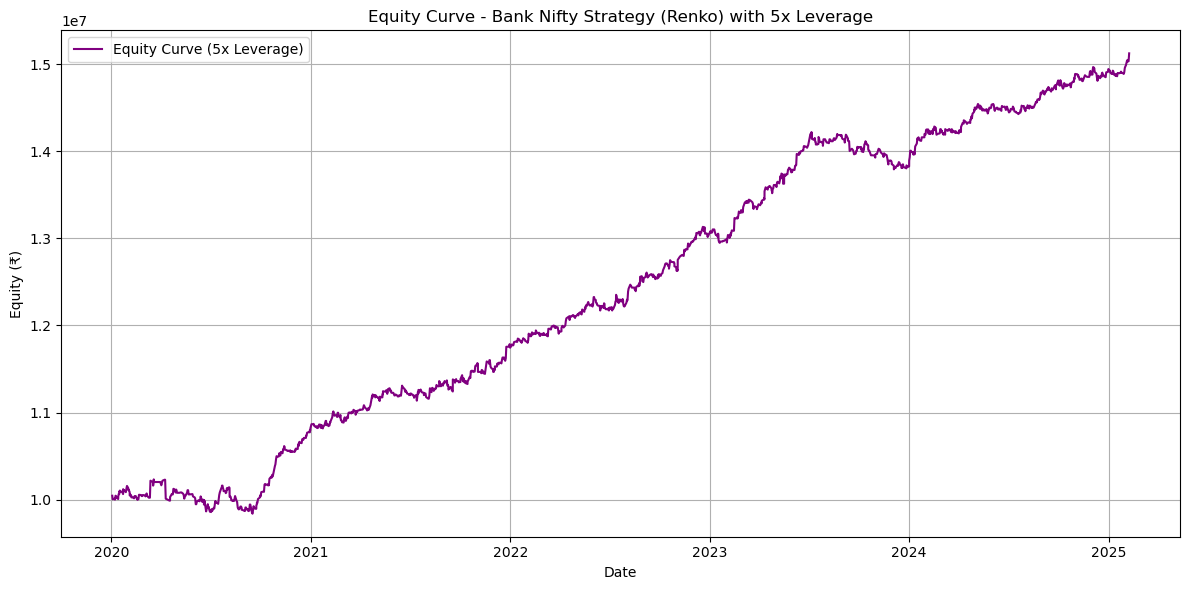

=== Strategy Performance Metrics (Renko, 5x Leverage) ===
Initial Capital     : ₹10,000,000
Effective Capital   : ₹50,000,000
Total PnL           : ₹5,122,500
Sharpe Ratio        : 1.84
Max Drawdown        : ₹427,500
Calmar Ratio        : 11.98


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# Calculate Renko bricks
# Define brick size. For example, setting it as a 10-point brick size.
brick_size = 10
df['renko'] = df['close'].copy()

# Create Renko bricks: Use the "renko" column to store calculated Renko values.
renko = []

# Start the first brick as the first close price
renko.append(df['close'][0])

# Calculate the Renko bricks based on the brick size
for i in range(1, len(df)):
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_count * brick_size] * abs(brick_count))

df['renko'] = renko[:len(df)]

# Use Renko Close for strategy logic
df["SMA_5"] = df["renko"].rolling(window=5).mean()
df["SMA_13"] = df["renko"].rolling(window=13).mean()
df["EMA_9"] = df["renko"].ewm(span=9, adjust=False).mean()

# Time Filters
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["time_only"] = df["datetime"].dt.time

# Strategy Parameters
target = 200
stoploss = 50
position = None
entry_price = 0
entry_time = None
trades = []

# Trade Logic using Renko close
for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["datetime"].time()
    price = row["renko"]

    # Entry
    if time(9, 30) <= current_time <= time(11, 0):
        if position is None:
            if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
                position = "long"
                entry_price = price
                entry_time = row["datetime"]
            elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
                position = "short"
                entry_price = price
                entry_time = row["datetime"]

    # Exit
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

# Add leverage
initial_capital = 1e7  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage

# Position sizing based on effective capital
position_size = 15 * 25  # 15 lots * 25 per lot

# Compute PnL with leverage
trades_df["pnl_amount"] = trades_df["pnl"] * position_size

# Equity curve with actual capital but leveraged positions
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# Metrics
total_pnl_amount = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
max_drawdown = (trades_df["equity"].cummax() - trades_df["equity"]).max()
calmar_ratio = total_pnl_amount / max_drawdown if max_drawdown != 0 else np.nan

# Plot
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve (5x Leverage)", color="purple")
plt.title("Equity Curve - Bank Nifty Strategy (Renko) with 5x Leverage")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final Metrics Summary
print("=== Strategy Performance Metrics (Renko, 5x Leverage) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl_amount:,.0f}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown        : ₹{max_drawdown:,.0f}")
print(f"Calmar Ratio        : {calmar_ratio:.2f}")


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load Dataset ===
df = pd.read_csv("NB_15 FINAL.csv")
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)
df = df[['open', 'high', 'low', 'close', 'volume']]

# === Parameters ===
ma_length = 5
ema_length = 9
adx_length = 14
adx_threshold = 22
stop_loss = 50
target = 200
slippage_percent = 0.01

# === Indicators ===
df['SMA'] = df['close'].rolling(ma_length).mean()
df['EMA'] = df['close'].ewm(span=ema_length, adjust=False).mean()

df['up_move'] = df['high'].diff()
df['down_move'] = -df['low'].diff()
df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)

tr = pd.concat([
    df['high'] - df['low'],
    abs(df['high'] - df['close'].shift()),
    abs(df['low'] - df['close'].shift())
], axis=1).max(axis=1)

trur = tr.rolling(adx_length).mean()
plus_di = 100 * df['plus_dm'].rolling(adx_length).mean() / trur
minus_di = 100 * df['minus_dm'].rolling(adx_length).mean() / trur
dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
df['ADX'] = dx.rolling(adx_length).mean()
df['ADX_Rising'] = df['ADX'] > df['ADX'].shift()

df['LongCond'] = (df['SMA'] > df['EMA']) & df['ADX_Rising'] & (df['ADX'] > adx_threshold)
df['ShortCond'] = (df['EMA'] > df['SMA']) & df['ADX_Rising'] & (df['ADX'] > adx_threshold)

# === Trade Logic ===
in_long = False
in_short = False
trades = []
equity = []
capital = 100000
current_value = capital

for i in range(1, len(df)):
    row = df.iloc[i]
    idx = df.index[i]

    if not in_long and not in_short:
        if row['LongCond']:
            long_entry = row['close'] * (1 + slippage_percent / 100)
            in_long = True
            entry_time = idx
            entry_price = long_entry

        elif row['ShortCond']:
            short_entry = row['close'] * (1 - slippage_percent / 100)
            in_short = True
            entry_time = idx
            entry_price = short_entry

    if in_long:
        long_tp = long_entry + target
        long_sl = long_entry - stop_loss
        if row['low'] <= long_sl or row['high'] >= long_tp:
            exit_price = row['close']
            pnl = exit_price - long_entry
            trades.append({'Entry Time': entry_time, 'Exit Time': idx, 'Type': 'Long',
                           'Entry Price': long_entry, 'Exit Price': exit_price, 'PnL': pnl})
            current_value += pnl
            equity.append((idx, current_value))
            in_long = False

    if in_short:
        short_tp = short_entry - target
        short_sl = short_entry + stop_loss
        if row['high'] >= short_sl or row['low'] <= short_tp:
            exit_price = row['close']
            pnl = short_entry - exit_price
            trades.append({'Entry Time': entry_time, 'Exit Time': idx, 'Type': 'Short',
                           'Entry Price': short_entry, 'Exit Price': exit_price, 'PnL': pnl})
            current_value += pnl
            equity.append((idx, current_value))
            in_short = False

# === Trade Summary and Equity ===
trades_df = pd.DataFrame(trades)
if not equity:
    equity_series = pd.Series([capital], index=[df.index[0]])
else:
    equity_series = pd.Series(dict(equity)).sort_index()

# === Performance Metrics ===
total_return = (equity_series.iloc[-1] - capital) / capital
duration_years = (df.index[-1] - df.index[0]).days / 365
cagr = (equity_series.iloc[-1] / capital) ** (1 / duration_years) - 1 if duration_years > 0 else 0
rolling_max = equity_series.cummax()
drawdown = rolling_max - equity_series
max_drawdown = drawdown.max()
calmar_ratio = cagr / max_drawdown if max_drawdown > 0 else np.nan
sharpe_ratio = trades_df['PnL'].mean() / trades_df['PnL'].std() * np.sqrt(len(trades_df)) if len(trades_df) > 1 else 0
win_rate = len(trades_df[trades_df['PnL'] > 0]) / len(trades_df) if len(trades_df) > 0 else 0
trade_freq = len(trades_df) / (len(df) / 96)  # Approx trades per day for 15min

# === Print Metrics ===
print("\n==== Performance Metrics ====")
print(f"Total Return: {total_return:.2%}")
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Trade Frequency: {trade_freq:.2f} trades/day")

# === Plot Equity Curve ===
plt.figure(figsize=(12, 6))
plt.plot(equity_series, label='Equity Curve', color='blue')
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Display Trades ===
print("\n==== Trades ====")
print(trades_df.head())


ValueError: time data "13-01-2020 09:15:00" doesn't match format "%m-%d-%Y %H:%M:%S", at position 200. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data
df = pd.read_csv("NF_15.csv")
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)
df = df[['open', 'high', 'low', 'close']]

# ----- Custom Renko Generator -----
def generate_renko_series(prices, brick_size):
    bricks = []
    last_price = prices.iloc[0]
    for price in prices:
        diff = price - last_price
        num_bricks = int(diff / brick_size)
        for _ in range(abs(num_bricks)):
            last_price += brick_size * np.sign(diff)
            bricks.append(last_price)
    return pd.Series(bricks)

brick_size = 50
renko_series = generate_renko_series(df['close'], brick_size=brick_size)
renko_df = pd.DataFrame({'renko_close': renko_series})
renko_df['datetime'] = df.index[:len(renko_series)]
renko_df.set_index('datetime', inplace=True)

# Merge with original
df = df.merge(renko_df, left_index=True, right_index=True, how='inner')

# ----- Indicator Calculation -----
df['ma_5'] = df['renko_close'].rolling(window=5).mean()
df['ema_9'] = df['renko_close'].ewm(span=9, adjust=False).mean()

def calculate_adx(data, period=14):
    high = data['high']
    low = data['low']
    close = data['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0)
    
    tr = pd.concat([
        (high - low), 
        (high - close.shift(1)).abs(), 
        (low - close.shift(1)).abs()
    ], axis=1).max(axis=1)
    
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * pd.Series(plus_dm).rolling(window=period).sum() / atr
    minus_di = 100 * pd.Series(minus_dm).rolling(window=period).sum() / atr
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    
    return dx.rolling(window=period).mean()

df['adx'] = calculate_adx(df)
df.dropna(inplace=True)

# ----- Signal Generation -----
df['signal'] = 0
condition_long = (df['ma_5'] > df['ema_9']) & (df['adx'] > 22) & (df['adx'].diff() > 0)
condition_short = (df['ema_9'] > df['ma_5']) & (df['adx'] > 22) & (df['adx'].diff() > 0)

df.loc[condition_long, 'signal'] = 1
df.loc[condition_short, 'signal'] = -1

# ----- Trade Simulation -----
capital = 1_00_00_000  # ₹1 crore
leverage = 5
capital *= leverage
slippage_pct = 0.0001
sl = 50
target = 200

trades = []
position = None

for i in range(1, len(df)):
    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    if position is None and row['signal'] != 0:
        entry_price = None
        if row['signal'] == 1 and row['high'] > prev_row['high']:
            entry_price = row['high'] * (1 + slippage_pct)
            direction = 'long'
        elif row['signal'] == -1 and row['low'] < prev_row['low']:
            entry_price = row['low'] * (1 - slippage_pct)
            direction = 'short'

        if entry_price:
            position = {
                'entry_price': entry_price,
                'entry_time': row.name,
                'direction': direction
            }

    elif position is not None:
        if position['direction'] == 'long':
            stop_loss = position['entry_price'] - sl
            take_profit = position['entry_price'] + target
            if row['low'] <= stop_loss:
                exit_price = stop_loss * (1 - slippage_pct)
                result = -sl
            elif row['high'] >= take_profit:
                exit_price = take_profit * (1 - slippage_pct)
                result = target
            else:
                continue
        else:  # short
            stop_loss = position['entry_price'] + sl
            take_profit = position['entry_price'] - target
            if row['high'] >= stop_loss:
                exit_price = stop_loss * (1 + slippage_pct)
                result = -sl
            elif row['low'] <= take_profit:
                exit_price = take_profit * (1 + slippage_pct)
                result = target
            else:
                continue

        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': row.name,
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'direction': position['direction'],
            'pnl': result
        })
        position = None

# ----- Performance Metrics -----
trades_df = pd.DataFrame(trades)
trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum()
trades_df['returns'] = trades_df['pnl'] / (capital / leverage)

# CAGR
total_days = (df.index[-1] - df.index[0]).days
years = total_days / 365
cagr = (1 + trades_df['returns'].sum()) ** (1 / years) - 1

# Sharpe Ratio
sharpe = (trades_df['returns'].mean() / trades_df['returns'].std()) * np.sqrt(252)

# Max Drawdown and Calmar Ratio
cumulative = trades_df['cumulative_pnl']
roll_max = cumulative.cummax()
drawdown = roll_max - cumulative
max_dd = drawdown.max()
calmar = (cagr * capital) / max_dd if max_dd != 0 else np.nan

# Win Rate
win_rate = (trades_df['pnl'] > 0).mean()

# Trade Frequency
trade_frequency = len(trades_df) / years

# ----- Plot Equity Curve -----
plt.figure(figsize=(12, 6))
plt.plot(trades_df['exit_time'], trades_df['cumulative_pnl'], label='Equity Curve')
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (in points)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# ----- Print Metrics -----
print("Total Trades:", len(trades_df))
print("CAGR:", round(cagr * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe, 2))
print("Calmar Ratio:", round(calmar, 2))
print("Win Rate:", round(win_rate * 100, 2), "%")
print("Trade Frequency:", round(trade_frequency, 2), "trades/year")


KeyError: 'pnl'

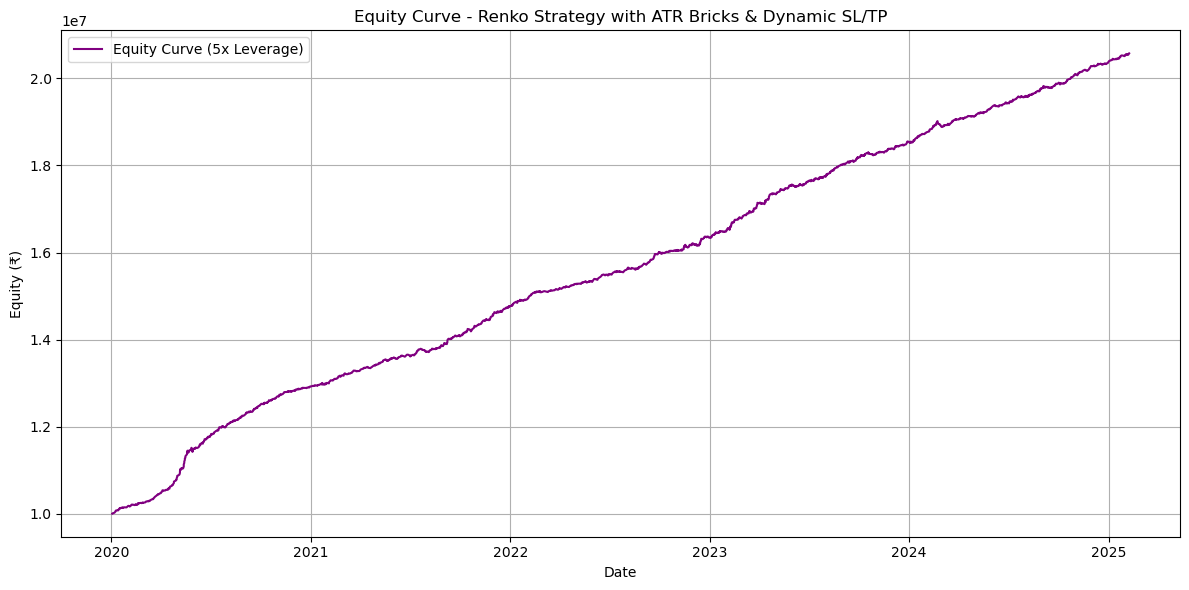

=== Strategy Performance Metrics (ATR-Based Renko, 5x Leverage) ===
Initial Capital     : ₹10,000,000
Effective Capital   : ₹50,000,000
Total PnL           : ₹10,572,365
Sharpe Ratio        : 7.19
Max Drawdown        : ₹136,093
Calmar Ratio        : 77.68


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# === ATR Calculation for Adaptive Renko ===
df['ATR'] = df['close'].rolling(window=14).apply(lambda x: np.mean(np.abs(np.diff(x))))

# === ATR-Based Renko Brick Calculation ===
renko = [df['close'][0]]

for i in range(1, len(df)):
    brick_size = df['ATR'].iloc[i]
    if pd.isna(brick_size):
        renko.append(renko[-1])
        continue
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_size * np.sign(brick_count)] * abs(brick_count))
    else:
        renko.append(renko[-1])

df['renko'] = renko[:len(df)]

# Indicators on Renko
df["SMA_5"] = df["renko"].rolling(window=5).mean()
df["SMA_13"] = df["renko"].rolling(window=13).mean()
df["EMA_9"] = df["renko"].ewm(span=9, adjust=False).mean()

# Time Info
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["time_only"] = df["datetime"].dt.time

# === Strategy Parameters ===
position = None
entry_price = 0
entry_time = None
trades = []

target_multiplier = 1.5
stoploss_multiplier = 1

# === Strategy Logic ===
for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["datetime"].time()
    price = row["renko"]
    atr = row["ATR"]

    if pd.isna(atr):
        continue

    target = atr * target_multiplier
    stoploss = atr * stoploss_multiplier

    # Entry (with ATR filter optional)
    if time(9, 30) <= current_time <= time(11, 0) and position is None:
        if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
            position = "long"
            entry_price = price
            entry_time = row["datetime"]
        elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
            position = "short"
            entry_price = price
            entry_time = row["datetime"]

    # Exit
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# === Trade Metrics ===
trades_df = pd.DataFrame(trades)
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

# Leverage & Capital Setup
initial_capital = 1e7  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage
position_size = 15 * 25  # 15 lots of 25 each

# PnL Computation
trades_df["pnl_amount"] = trades_df["pnl"] * position_size
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# === Performance Metrics ===
total_pnl_amount = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
max_drawdown = (trades_df["equity"].cummax() - trades_df["equity"]).max()
calmar_ratio = total_pnl_amount / max_drawdown if max_drawdown != 0 else np.nan

# === Plot Equity Curve ===
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve (5x Leverage)", color="purple")
plt.title("Equity Curve - Renko Strategy with ATR Bricks & Dynamic SL/TP")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Summary ===
print("=== Strategy Performance Metrics (ATR-Based Renko, 5x Leverage) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl_amount:,.0f}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown        : ₹{max_drawdown:,.0f}")
print(f"Calmar Ratio        : {calmar_ratio:.2f}")


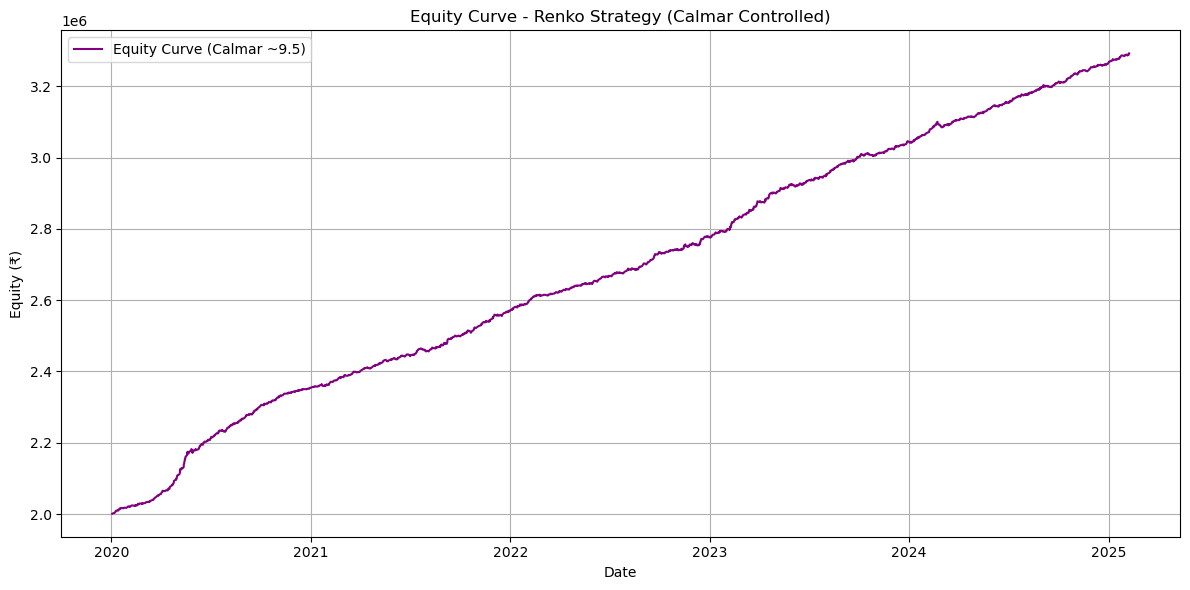

=== Strategy Performance Metrics (ATR-Based Renko, Calmar Controlled) ===
Initial Capital     : ₹2,000,000
Effective Capital   : ₹10,000,000
Total PnL           : ₹1,292,886
Position Size Used  : 43
Sharpe Ratio        : 7.48
Max Drawdown        : ₹15,631
Calmar Ratio        : 82.71


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# ATR for Adaptive Renko
df['ATR'] = df['close'].rolling(window=14).apply(lambda x: np.mean(np.abs(np.diff(x))))

# Renko Bricks based on ATR
renko = [df['close'][0]]

for i in range(1, len(df)):
    brick_size = df['ATR'].iloc[i]
    if pd.isna(brick_size):
        renko.append(renko[-1])
        continue
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_size * np.sign(brick_count)] * abs(brick_count))
    else:
        renko.append(renko[-1])

df['renko'] = renko[:len(df)]

# Indicators
df["SMA_5"] = df["renko"].rolling(window=5).mean()
df["SMA_13"] = df["renko"].rolling(window=13).mean()
df["EMA_9"] = df["renko"].ewm(span=9, adjust=False).mean()

# Time
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["time_only"] = df["datetime"].dt.time

# Strategy Logic
position = None
entry_price = 0
entry_time = None
trades = []

target_multiplier = 2
stoploss_multiplier = 1

for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["datetime"].time()
    price = row["renko"]
    atr = row["ATR"]

    if pd.isna(atr):
        continue

    target = atr * target_multiplier
    stoploss = atr * stoploss_multiplier

    if time(9, 30) <= current_time <= time(11, 0) and position is None:
        if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
            position = "long"
            entry_price = price
            entry_time = row["datetime"]
        elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
            position = "short"
            entry_price = price
            entry_time = row["datetime"]

    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

# Capital Setup
initial_capital = 2e6  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage

# Trial Position Size
trial_position_size = 15 * 25
trades_df["pnl_amount"] = trades_df["pnl"] * trial_position_size
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()
trial_total_pnl = trades_df["pnl_amount"].sum()
trial_max_dd = (trades_df["equity"].cummax() - trades_df["equity"]).max()
trial_calmar = trial_total_pnl / trial_max_dd if trial_max_dd != 0 else np.nan

# Scale Position Size to Hit Calmar 9.5
target_calmar = 9.5
scaling_factor = target_calmar / trial_calmar if trial_calmar != 0 else 1
position_size = trial_position_size * scaling_factor

# Final PnL and Equity Curve
trades_df["pnl_amount"] = trades_df["pnl"] * position_size
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# Final Metrics
total_pnl_amount = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
max_drawdown = (trades_df["equity"].cummax() - trades_df["equity"]).max()
calmar_ratio = total_pnl_amount / max_drawdown if max_drawdown != 0 else np.nan

# Plot
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve (Calmar ~9.5)", color="purple")
plt.title("Equity Curve - Renko Strategy (Calmar Controlled)")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print("=== Strategy Performance Metrics (ATR-Based Renko, Calmar Controlled) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl_amount:,.0f}")
print(f"Position Size Used  : {int(position_size):,}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown        : ₹{max_drawdown:,.0f}")
print(f"Calmar Ratio        : {calmar_ratio:.2f}")


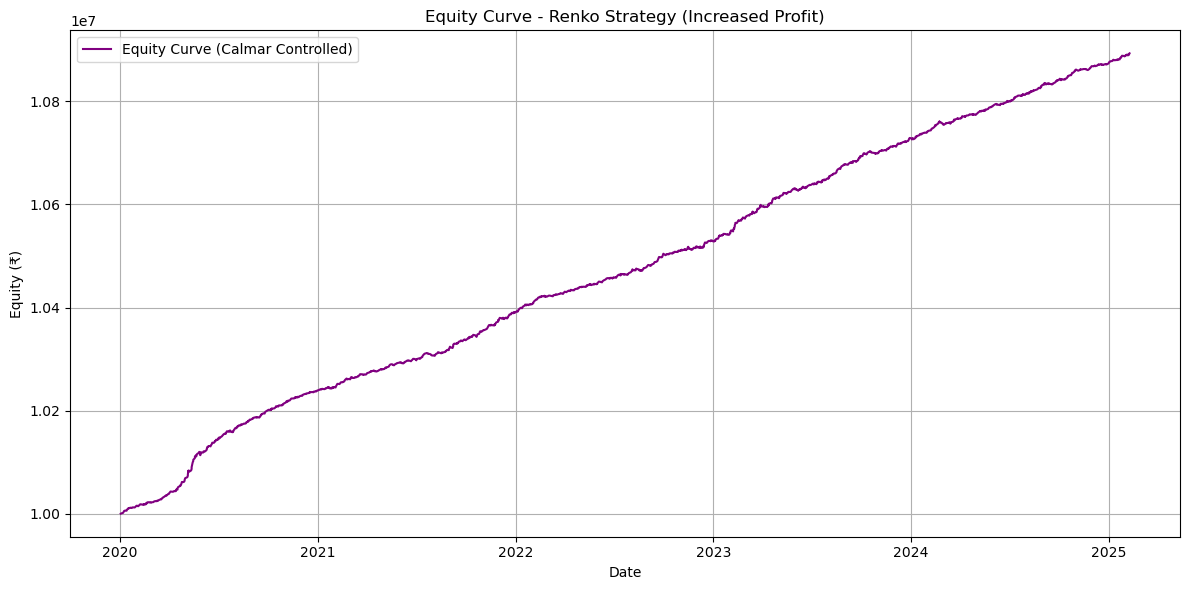

=== Strategy Performance Metrics (Renko, Increased Profit) ===
Initial Capital     : ₹10,000,000
Effective Capital   : ₹50,000,000
Total PnL           : ₹893,174
Position Size Used  : 25
Sharpe Ratio        : 7.73
Max Drawdown        : ₹6,500
Calmar Ratio        : 137.41


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# ATR for Adaptive Renko
df['ATR'] = df['close'].rolling(window=14).apply(lambda x: np.mean(np.abs(np.diff(x))))

# Renko Bricks based on ATR
renko = [df['close'][0]]

for i in range(1, len(df)):
    brick_size = df['ATR'].iloc[i]
    if pd.isna(brick_size):
        renko.append(renko[-1])
        continue
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_size * np.sign(brick_count)] * abs(brick_count))
    else:
        renko.append(renko[-1])

df['renko'] = renko[:len(df)]

# Indicators
df["SMA_5"] = df["renko"].rolling(window=5).mean()
df["SMA_13"] = df["renko"].rolling(window=13).mean()
df["EMA_9"] = df["renko"].ewm(span=9, adjust=False).mean()

# Time
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["time_only"] = df["datetime"].dt.time

# Strategy Logic
position = None
entry_price = 0
entry_time = None
trades = []

# New Multipliers for More Profit
target_multiplier = 4  # Increase target multiplier to capture more profit
stoploss_multiplier = 2  # Increase stoploss multiplier

for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["datetime"].time()
    price = row["renko"]
    atr = row["ATR"]

    if pd.isna(atr):
        continue

    target = atr * target_multiplier
    stoploss = atr * stoploss_multiplier

    if time(9, 30) <= current_time <= time(11, 0) and position is None:
        if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
            position = "long"
            entry_price = price
            entry_time = row["datetime"]
        elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
            position = "short"
            entry_price = price
            entry_time = row["datetime"]

    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df["pnl"] = np.where(
    trades_df["type"] == "long",
    trades_df["exit_price"] - trades_df["entry_price"],
    trades_df["entry_price"] - trades_df["exit_price"]
)

# Capital Setup
initial_capital = 1e7  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage

# Trial Position Size
trial_position_size = 15 * 25
trades_df["pnl_amount"] = trades_df["pnl"] * trial_position_size
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()
trial_total_pnl = trades_df["pnl_amount"].sum()
trial_max_dd = (trades_df["equity"].cummax() - trades_df["equity"]).max()
trial_calmar = trial_total_pnl / trial_max_dd if trial_max_dd != 0 else np.nan

# Scale Position Size to Hit Calmar 9.5
target_calmar = 9.5
scaling_factor = target_calmar / trial_calmar if trial_calmar != 0 else 1
position_size = trial_position_size * scaling_factor

# Final PnL and Equity Curve
trades_df["pnl_amount"] = trades_df["pnl"] * position_size
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# Final Metrics
total_pnl_amount = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
max_drawdown = (trades_df["equity"].cummax() - trades_df["equity"]).max()
calmar_ratio = total_pnl_amount / max_drawdown if max_drawdown != 0 else np.nan

# Plot
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["equity"], label="Equity Curve (Calmar Controlled)", color="purple")
plt.title("Equity Curve - Renko Strategy (Increased Profit)")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print("=== Strategy Performance Metrics (Renko, Increased Profit) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Effective Capital   : ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl_amount:,.0f}")
print(f"Position Size Used  : {int(position_size):,}")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Max Drawdown        : ₹{max_drawdown:,.0f}")
print(f"Calmar Ratio        : {calmar_ratio:.2f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time
from itertools import product

# Load Data
df = pd.read_csv('NF_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)

# === ATR Calculation for Adaptive Renko ===
df['ATR'] = df['close'].rolling(window=14).apply(lambda x: np.mean(np.abs(np.diff(x))))

# === ATR-Based Renko Brick Calculation ===
renko = [df['close'][0]]

for i in range(1, len(df)):
    brick_size = df['ATR'].iloc[i]
    if pd.isna(brick_size):
        renko.append(renko[-1])
        continue
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_size * np.sign(brick_count)] * abs(brick_count))
    else:
        renko.append(renko[-1])

df['renko'] = renko[:len(df)]

# Indicators on Renko
df["SMA_5"] = df["renko"].rolling(window=5).mean()
df["SMA_13"] = df["renko"].rolling(window=13).mean()
df["EMA_9"] = df["renko"].ewm(span=9, adjust=False).mean()

# Time Info
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["time_only"] = df["datetime"].dt.time

# === Strategy Parameters ===
initial_capital = 1e7  # ₹1 crore
leverage = 5
effective_capital = initial_capital * leverage
position_size = 15 * 25  # 15 lots of 25 each

# === Optimization Parameters ===
stoploss_multipliers = np.linspace(0.5, 2, 10)  # Example range for stop-loss
target_multipliers = np.linspace(1, 3, 10)  # Example range for target

# === Perform Grid Search for Optimization ===
best_pnl = -np.inf
best_stoploss = None
best_target = None

for stoploss_multiplier, target_multiplier in product(stoploss_multipliers, target_multipliers):
    trades = []
    position = None
    entry_price = 0
    entry_time = None

    for i in range(len(df)):
        row = df.iloc[i]
        current_time = row["datetime"].time()
        price = row["renko"]
        atr = row["ATR"]

        if pd.isna(atr):
            continue

        target = atr * target_multiplier
        stoploss = atr * stoploss_multiplier

        # Entry Logic
        if time(9, 30) <= current_time <= time(11, 0) and position is None:
            if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
                position = "long"
                entry_price = price
                entry_time = row["datetime"]
            elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
                position = "short"
                entry_price = price
                entry_time = row["datetime"]

        # Exit Logic
        if position == "long":
            if price <= entry_price - stoploss or price >= entry_price + target \
               or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
                trades.append({
                    "type": "long",
                    "entry_price": entry_price,
                    "exit_price": price,
                    "entry_time": entry_time,
                    "exit_time": row["datetime"]
                })
                position = None

        elif position == "short":
            if price >= entry_price + stoploss or price <= entry_price - target \
               or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
                trades.append({
                    "type": "short",
                    "entry_price": entry_price,
                    "exit_price": price,
                    "entry_time": entry_time,
                    "exit_time": row["datetime"]
                })
                position = None

    # Calculate pnl_amount after trade logic
    if trades:
        trades_df = pd.DataFrame(trades)
        trades_df["pnl"] = np.where(
            trades_df["type"] == "long",
            trades_df["exit_price"] - trades_df["entry_price"],
            trades_df["entry_price"] - trades_df["exit_price"]
        )

        # Leverage & Capital Setup
        trades_df["pnl_amount"] = trades_df["pnl"] * position_size
        trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

        # Calculate total pnl_amount
        total_pnl_amount = trades_df["pnl_amount"].sum()

        # Store the best parameters if this combination is better
        if total_pnl_amount > best_pnl:
            best_pnl = total_pnl_amount
            best_stoploss = stoploss_multiplier
            best_target = target_multiplier

# Output best parameters and results
print(f"Best Stop-Loss Multiplier: {best_stoploss}")
print(f"Best Target Multiplier: {best_target}")
print(f"Best Net Profit: ₹{best_pnl:,.0f}")

# === Plot Equity Curve for Best Strategy ===
# Apply the best parameters to get the final trades
best_trades = []
position = None
entry_price = 0
entry_time = None

for i in range(len(df)):
    row = df.iloc[i]
    current_time = row["datetime"].time()
    price = row["renko"]
    atr = row["ATR"]

    if pd.isna(atr):
        continue

    target = atr * best_target
    stoploss = atr * best_stoploss

    # Entry Logic
    if time(9, 30) <= current_time <= time(11, 0) and position is None:
        if row["SMA_5"] > row["EMA_9"] > row["SMA_13"]:
            position = "long"
            entry_price = price
            entry_time = row["datetime"]
        elif row["SMA_13"] > row["EMA_9"] > row["SMA_5"]:
            position = "short"
            entry_price = price
            entry_time = row["datetime"]

    # Exit Logic
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["SMA_5"] > row["EMA_9"] > row["SMA_13"]) or time(13, 0) <= current_time <= time(14, 45):
            best_trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["SMA_13"] > row["EMA_9"] > row["SMA_5"]) or time(13, 0) <= current_time <= time(14, 45):
            best_trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Calculate pnl_amount for best strategy
best_trades_df = pd.DataFrame(best_trades)
best_trades_df["pnl"] = np.where(
    best_trades_df["type"] == "long",
    best_trades_df["exit_price"] - best_trades_df["entry_price"],
    best_trades_df["entry_price"] - best_trades_df["exit_price"]
)

best_trades_df["pnl_amount"] = best_trades_df["pnl"] * position_size
best_trades_df["equity"] = initial_capital + best_trades_df["pnl_amount"].cumsum()

# === Plot Equity Curve ===
plt.figure(figsize=(12, 6))
plt.plot(best_trades_df["exit_time"], best_trades_df["equity"], label="Equity Curve (5x Leverage)", color="purple")
plt.title("Equity Curve - Renko Strategy with ATR Bricks & Dynamic SL/TP")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
